# level of analysis : inter subjects (group level)

In [ ]:
import mne
import os 
import numpy as np
import submitit
import pandas as pd 
import math 
import matplotlib.pyplot as plt
from mne.stats import permutation_cluster_test
import h5py


# combine data for each subject

In [ ]:

def load_tfr(pid, ch_name, version ):
    """
    Load time-frequency representation (TFR) data using MNE.

    Parameters:
    pid (str): Participant ID.
    ch_name (str): Channel name.

    Returns:
    epochTFR (mne.time_frequency.EpochsTFR or None): The loaded TFR data. Returns None if the file is not found.
    """
    ch_name = ch_name.replace('/', '&')
    tfr_path = os.path.join(base_TF_path, pid, f'powerLF_{version}_{ch_name}.h5')
    if os.path.isfile(tfr_path):
        epochTFR = mne.time_frequency.read_tfrs(tfr_path)
        return epochTFR
    else:
        print(f'TFR file not found for {pid} - {ch_name}')
        return None


def compute_diff_average_tfr(epochTFR, condition1_trial, condition2_trial):
    """
    Compute the difference in average TFR between two conditions.

    Parameters:
    epochTFR (mne.time_frequency.EpochsTFR): The TFR data.
    condition1_trial (list of int): Indices of trials for condition 1.
    condition2_trial (list of int): Indices of trials for condition 2.

    Returns:
    diff_data (numpy.ndarray): The difference in average TFR between the two conditions.
    c1_data (numpy.ndarray): The log-transformed TFR data for condition 1.
    c2_data (numpy.ndarray): The log-transformed TFR data for condition 2.
    """
    c1_data = np.log10(epochTFR.data[condition1_trial].squeeze() + 1e-10)
    c2_data = np.log10(epochTFR.data[condition2_trial].squeeze() + 1e-10)
    c1_data_av = np.mean(c1_data, axis=0)
    c2_data_av = np.mean(c2_data, axis=0)
    diff_data = c1_data_av - c2_data_av
    return c1_data_av, c2_data_av, diff_data


def combine_layer(row, version ='csd' ):

    
    pid = row['pid']
    layer_names=['layer1','layer2','layer4','layer5','layer6']

    base_TF_path = '/mnt/data/AdaptiveControl/IBLrawdata/TF_data'
    path_epoch_quality = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/{pid}/epoch_quality_{version}.csv'

    quality_data = pd.read_csv(path_epoch_quality)

    bad_trials = quality_data[(quality_data['skewness'] > 1.5) | (quality_data['max_power'] > 500) ]['epoch'].values
    bad_trials = list(set(bad_trials))
    for condition, signif_channel_col in {
        'Stim_NoStim': 'signif_channel_StimNoStim'
    }.items():
        signif_channels = row[signif_channel_col]
        if pd.isna(signif_channels) or not signif_channels:
            continue
        if isinstance(signif_channels, str):
            signif_channels = eval(signif_channels)
            
        layer_data1 = {}
        layer_data2 = {}
        for item in signif_channels:
            
            # Ensure each item is a pair (ch_name, acc_value)
            if not isinstance(item, (list, tuple)) or len(item) != 2:
                print(f'Unexpected item format: {item} in {pid} - {condition}')
                return
            
            ch_name, acc_value = item
            layer_number = int(ch_name[4])  # Extracting the layer number
            
            if layer_number != 5:
                continue
            print(f' {ch_name} - acc = {acc_value}')
            
            epochTFR = load_tfr(pid, ch_name, version = version)
            if epochTFR is None:
                continue
            
            meta = epochTFR.metadata.reset_index()

            
            if condition == 'Stim_NoStim':
                condition1_trial = meta.index[(meta['contrastLeft'] == 1) | (meta['contrastRight'] == 1)].tolist()
                condition2_trial = meta.index[(meta['contrastLeft'] < 0.1) | (meta['contrastRight'] < 0.1)].tolist()
            else:
                continue
            
            # Exclude noisy trials
            condition1_trial = [trial for trial in condition1_trial if trial not in bad_trials]
            condition2_trial = [trial for trial in condition2_trial if trial not in bad_trials]
            
            c1_data_av, c2_data_av, diff_data = compute_diff_average_tfr(epochTFR, condition1_trial, condition2_trial)
            print(f'Computed difference in average TFR for {pid} - {ch_name} - {condition}')
            
            del epochTFR  # Free up memory
            
            if layer_number not in layer_data1 :
                layer_data1[layer_number] = []
                layer_data2[layer_number] = []
            layer_data1[layer_number].append(c1_data_av)
            layer_data2[layer_number].append(c2_data_av)
            
        layer_objects1 = {}
        for layer_number, data_list in layer_data1.items():
            combined_data = np.stack(data_list)  # Combine data for channels in this layer
            combined_data = np.mean(combined_data, axis=0, keepdims= True) # Average across channels
            layer_objects1[layer_number] = combined_data
            print(f'Layer {layer_number} data shape: {combined_data.shape}')
        
        layer_objects2 = {}
        for layer_number, data_list in layer_data2.items():
            combined_data = np.stack(data_list)
            combined_data = np.mean(combined_data, axis=0, keepdims= True)
            layer_objects2[layer_number] = combined_data
            print(f'Layer {layer_number} data shape: {combined_data.shape}')
        
        # save layer_objects
        save_path = os.path.join(base_TF_path, pid, f'TFR_LF_{condition}_all_{version}_testepsilon.h5')
        with h5py.File(save_path, 'w') as hf:   
            for layer_name in layer_names:
                layer_number = int(layer_name[-1])  # Extract the layer number from the layer name
                if layer_number in layer_objects1:
                    dataset_name = f'{layer_name}_c1'
                    hf.create_dataset(dataset_name, data=layer_objects1[layer_number])
                if layer_number in layer_objects2:
                    dataset_name = f'{layer_name}_c2'
                    hf.create_dataset(dataset_name, data=layer_objects2[layer_number])
                    
        print(f'Saved combined data for {pid} - {condition} in {save_path}')
                

In [ ]:
import os
import pandas as pd
import numpy as np
import mne
from mne.stats import permutation_cluster_test
import h5py
import submitit

base_eid_path = '/mnt/data/AdaptiveControl/IBLrawdata/eid_data'
base_TF_path = '/mnt/data/AdaptiveControl/IBLrawdata/TF_data'
path_summary_data = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data_with_significant_channels.csv'
summary_data = pd.read_csv(path_summary_data)

# summary_data= summary_data[11:12]

executor = submitit.AutoExecutor(folder="logs")

# Define maxjobs to a low value to illustrate
maxjobs = 100

# Pass parameter to the executor
executor.update_parameters(slurm_array_parallelism=maxjobs, mem_gb=16, timeout_min=600, slurm_partition="CPU", cpus_per_task=1)


# Execute the job (note the .map_array command that different from the .submit command used above)
jobs = executor.map_array(combine_layer, [row for _, row in summary_data.iterrows()])


# compute the average over all subjects with permutation results 

In [ ]:

def group_level_permutation(condition = 'Stim_NoStim' , layer = 'layer5', version = 'csd'):

    '''
    

    '''
    TF_path = '/mnt/data/AdaptiveControl/IBLrawdata/TF_data/'
    group_level_data_path = f'/mnt/data/AdaptiveControl/IBLrawdata/group_level_data/{layer}'
    os.makedirs(group_level_data_path, exist_ok=True)
    X1=[]
    X2 = []
    file_name = f'TFR_LF_{condition}_all_{version}_testepsilon.h5'
    no_combine_file_pid = [] # list of pid that do not have the combine file
    dataset_name1 = f'{layer}_c1'
    dataset_name2 = f'{layer}_c2'
    total_subject = 0
    for pid in os.listdir(TF_path):
        
        if os.path.isfile(os.path.join(TF_path, pid, file_name)):
            
            with h5py.File(os.path.join(TF_path, pid, file_name), 'r') as hf:
                try:
                    x1 = hf[dataset_name1][:] #x shape = (1, n_freqs, n_times)
                    x2 = hf[dataset_name2][:] #x shape = (1, n_freqs, n_times)
                    X1.append(x1)
                    X2.append(x2)
                    total_subject += 1
                except:
                    print(f'no data for {pid} in {layer}')
                    continue
        else:
            no_combine_file_pid.append(pid)
    
    X1stack = np.vstack(X1) # X1stack shape = (n_subjects, n_freqs, n_times) for condition one for example stim trials
    X2stack = np.vstack(X2) # X2stack shape = (n_subjects, n_freqs, n_times) for condition two for example no stim trials
    
    
    print(f'shape of X1stack: {X1stack.shape}')
    print(f'shape of X2stack: {X2stack.shape}')
    diff_tfr = X2stack - X1stack # shape = (n_subjects, n_freqs, n_times)
    return diff_tfr
                
    
     

In [ ]:
import os
import pandas as pd
import numpy as np
import mne
from mne.stats import permutation_cluster_test
import h5py
import submitit

executor = submitit.AutoExecutor(folder=os.getcwd()+'/logs/')
executor.update_parameters(mem_gb=20, timeout_min=400, slurm_partition="CPU", cpus_per_task=1, slurm_comment='group_level_permutation')
job = executor.submit(group_level_permutation)

In [ ]:
job.done()

In [ ]:
data = job.result()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' is your 3D NumPy array with shape (number_subjects, freqs, times)
# Example: data = np.random.rand(5, 10, 15)  # 5 subjects, 10 frequency bands, 15 time points

number_subjects, freqs, times = data.shape

# Create a plot for each subject
for i in range(number_subjects):
    plt.figure(figsize=(10, 6))
    plt.imshow(data[i, :, :], aspect='auto', origin='lower')
    plt.colorbar(label='Power')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Subject {i+1} Time-Frequency Representation')
    plt.show()


In [16]:
pid = 'f9d8aacd-b2a0-49f2-bd71-c2f5aadcfdd1'

file_name = 'TFR_LF_Stim_NoStim_all_csd_testepsilon.h5'
no_combine_file_pid = [] # list of pid that do not have the combine file
TF_path = '/mnt/data/AdaptiveControl/IBLrawdata/TF_data/'

X1=[]
X2 = []

if os.path.isfile(os.path.join(TF_path, pid, file_name)):
    
    with h5py.File(os.path.join(TF_path, pid, file_name), 'r') as hf:

        try:
            x1 = hf['layer5_c1'][:] #x shape = (1, n_freqs, n_times)
            x2 = hf['layer5_c2'][:] #x shape = (1, n_freqs, n_times)
            X1.append(x1)
            X2.append(x2)
        except:
            print(f'no data for {pid} in ')
            
else:
    print(f'no combine file for {pid}')

X1stack = np.vstack(X1) # X1stack shape = (n_subjects, n_freqs, n_times) for condition one for example stim trials
X2stack = np.vstack(X2) # X2stack shape = (n_subjects, n_freqs, n_times) for condition two for example no stim trials


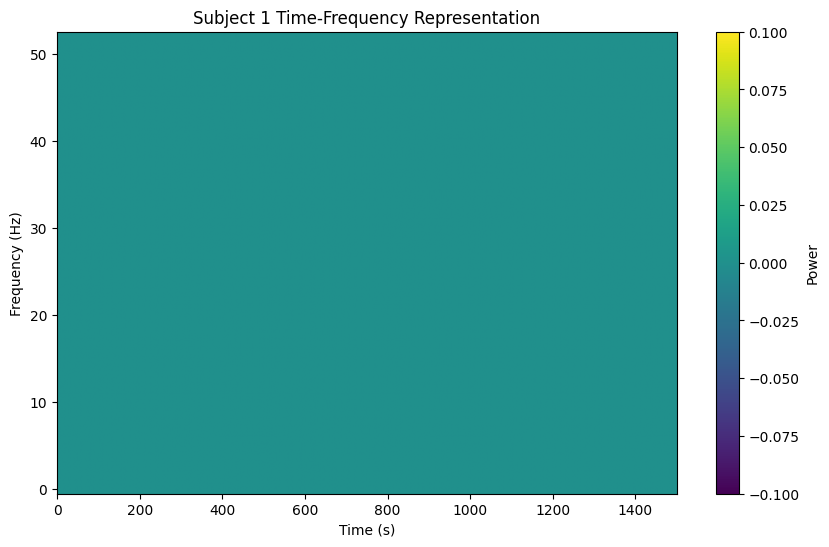

In [19]:
data = X2stack - X1stack # shape = (n_subjects, n_freqs, n_times)
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' is your 3D NumPy array with shape (number_subjects, freqs, times)
# Example: data = np.random.rand(5, 10, 15)  # 5 subjects, 10 frequency bands, 15 time points

number_subjects, freqs, times = data.shape

# Create a plot for each subject
for i in range(number_subjects):
    plt.figure(figsize=(10, 6))
    plt.imshow(data[i, :, :], aspect='auto', origin='lower')
    plt.colorbar(label='Power')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Subject {i+1} Time-Frequency Representation')
    plt.show()
